Visualize the grid search for the best pivoted document length normalization slope $s$.

In [1]:
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import itertools

lineformats = itertools.cycle(["-%s" % marker for marker in Line2D.filled_markers])
results = pd.read_csv("results.csv", header=None, sep=",", usecols=(0,1))

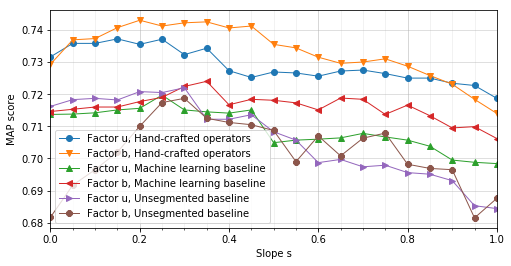

In [2]:
naming = {"segmented_aggregation" : "Hand-crafted operators",
          "segmented_ml" : "Machine learning baseline",
          "unsegmented" : "Unsegmented baseline"}
plt.figure(figsize=(8, 4))
for method in ("segmented_aggregation", "segmented_ml", "unsegmented"):
    for normalization in ("u", "b"):
        X = []
        Y = []
        for _, config, map_score in results.itertuples():
            match = re.search("%s.*%s_s=([0-9.]*)_" % (method, normalization), config)
            if not match:
                continue
            slope = float(match.groups()[0])
            map_score = float(map_score)
            X.append(slope)
            Y.append(map_score)
        linefmt = next(lineformats)
        plt.plot(*zip(*sorted(zip(X, Y), key=lambda x: x[0])), linefmt,
                 linewidth=1, label="Factor %s, %s" % (normalization, naming[method]))
plt.xlabel("Slope s")
plt.ylabel("MAP score")
plt.xlim((0.0, 1.0))
plt.axes().set_xticks(np.linspace(0.0, 1.0, 21), minor=True)
plt.legend()
plt.axes().grid(which='minor', alpha=0.2)                                                
plt.axes().grid(which='major', alpha=0.5)   
plt.savefig("figure-tfidf.pdf")
plt.show()

Visualize the grid search for the best BM25 $k_1, k_3,$ and $b$ parameters.

In [3]:
cache = dict()
def get_measurements(method, k1=None, k3=None, b=None):
    if (method, k1, k3, b) in cache:
        for map_score in cache[(method, k1, k3, b)]:
            yield map_score
    else:
        cached_list = []
        cache[(method, k1, k3, b)] = cached_list
        if k1 is not None:
            k1 = "%.02f" % k1
        else:
            k1 = "([0-9.]*)"
        if k3 is not None:
            k3 = "%d" % k3
        else:
            k3 = "([0-9.]*)"
        if b is not None:
            b = "%.02f" % b
        else:
            b = "([0-9.]*)"
        for _, config, map_score in results.itertuples():
            match = re.search("%s.*bm25_k1=%s_k3=%s_b=%s" % (method, k1, k3, b), config)
            if not match:
                continue
            cached_list.append(map_score)
            yield map_score

In [4]:
dimensions = 3

def display_plots(method):
    plt.figure(figsize=(18,15))

    # Two-dimensional plots
    ax = plt.subplot(dimensions, dimensions, 1)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
    X = np.linspace(1.0, 2.0, 21)
    Y = [np.mean(list(get_measurements(method, k1=k1))) for k1 in X]
    plt.plot(X, Y, "-o")
    plt.xlabel("k1")
    plt.ylabel("MAP score")
    plt.xlim((1.0, 2.0))

    ax = plt.subplot(dimensions, dimensions, 5)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
    X = np.linspace(0, 1000, 21)
    Y = [np.mean(list(get_measurements(method, k3=k3))) for k3 in X]
    plt.plot(X, Y, "-o")
    plt.xlabel("k3")
    plt.ylabel("MAP score")
    plt.xlim((50, 1000))

    ax = plt.subplot(dimensions, dimensions, 9)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%g'))
    X = np.linspace(0.0, 1.0, 21)
    Y = [np.mean(list(get_measurements(method, b=b))) for b in X]
    plt.plot(X, Y, "-o")
    plt.xlabel("b")
    plt.ylabel("MAP score")
    plt.xlim((0.0, 1.0))

    # Three-dimensional plots
    ax = plt.subplot(dimensions, dimensions, 2, projection='3d')
    X = np.linspace(1.0, 2.0, 21)
    Y = np.linspace(0, 1000, 21)
    Z = [[np.mean(list(get_measurements(method, k1=k1, k3=k3))) for k3 in Y] for k1 in X]
    ax = plt.subplot(dimensions, dimensions, 2, projection='3d')
    ax.view_init(45, -60)
    ax.plot_wireframe(*np.meshgrid(X, Y), Z, linewidth=0.5)
    ax.set_xlabel("k1")
    ax.set_ylabel("k3")
    ax.set_zlabel("MAP score", labelpad=5)

    ax = plt.subplot(dimensions, dimensions, 3, projection='3d')
    X = np.linspace(1.0, 2.0, 21)
    Y = np.linspace(0.0, 1.0, 21)
    Z = [[np.mean(list(get_measurements(method, k1=k1, b=b))) for b in Y] for k1 in X]
    ax.view_init(45, -60)
    ax.plot_wireframe(*np.meshgrid(X, Y), Z, linewidth=0.5)
    ax.set_xlabel("k1")
    ax.set_ylabel("b")
    ax.set_zlabel("MAP score", labelpad=5)

    ax = plt.subplot(dimensions, dimensions, 6, projection='3d')
    X = np.linspace(0, 1000, 21)
    Y = np.linspace(0.0, 1.0, 21)
    Z = [[np.mean(list(get_measurements(method, k3=k3, b=b))) for b in Y] for k3 in X]
    ax.view_init(45, -60)
    ax.plot_wireframe(*np.meshgrid(X, Y), Z, linewidth=0.5)
    ax.set_xlabel("k3")
    ax.set_ylabel("b")
    ax.set_zlabel("MAP score", labelpad=5)
    
    plt.savefig("figure-bm25-%s.pdf" %method)

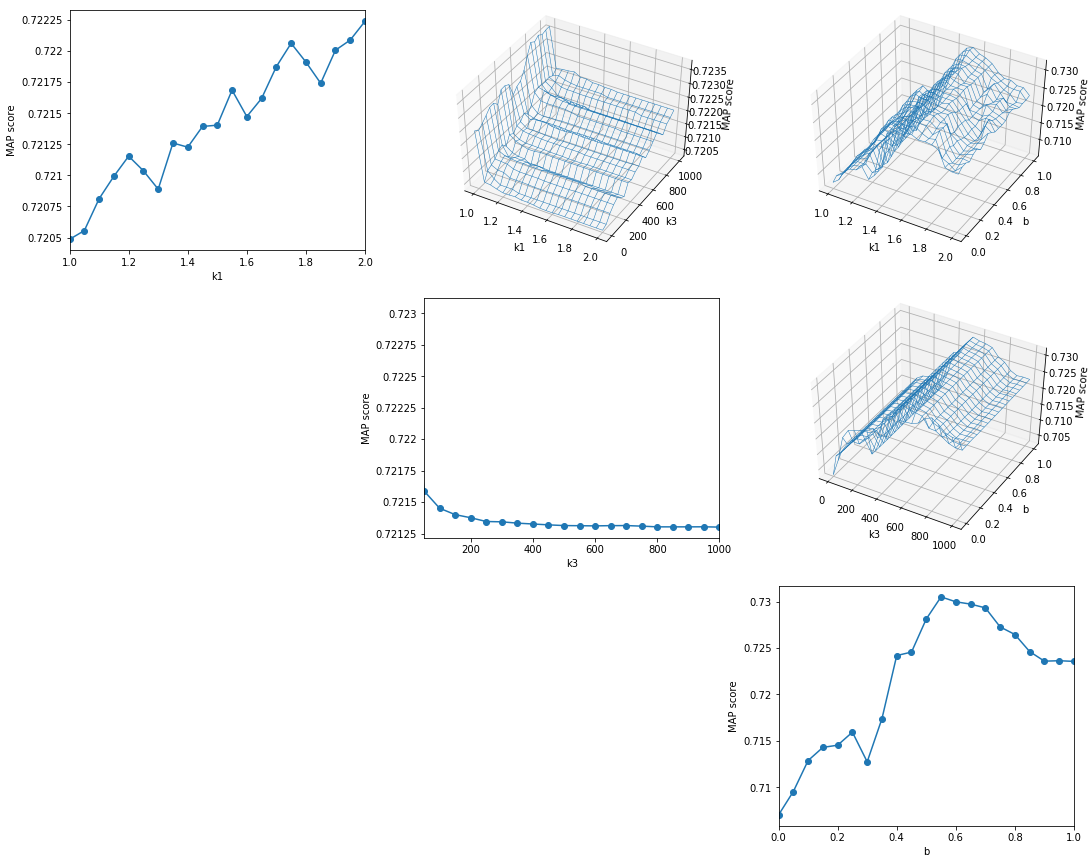

In [8]:
%matplotlib inline
display_plots("segmented_aggregation")

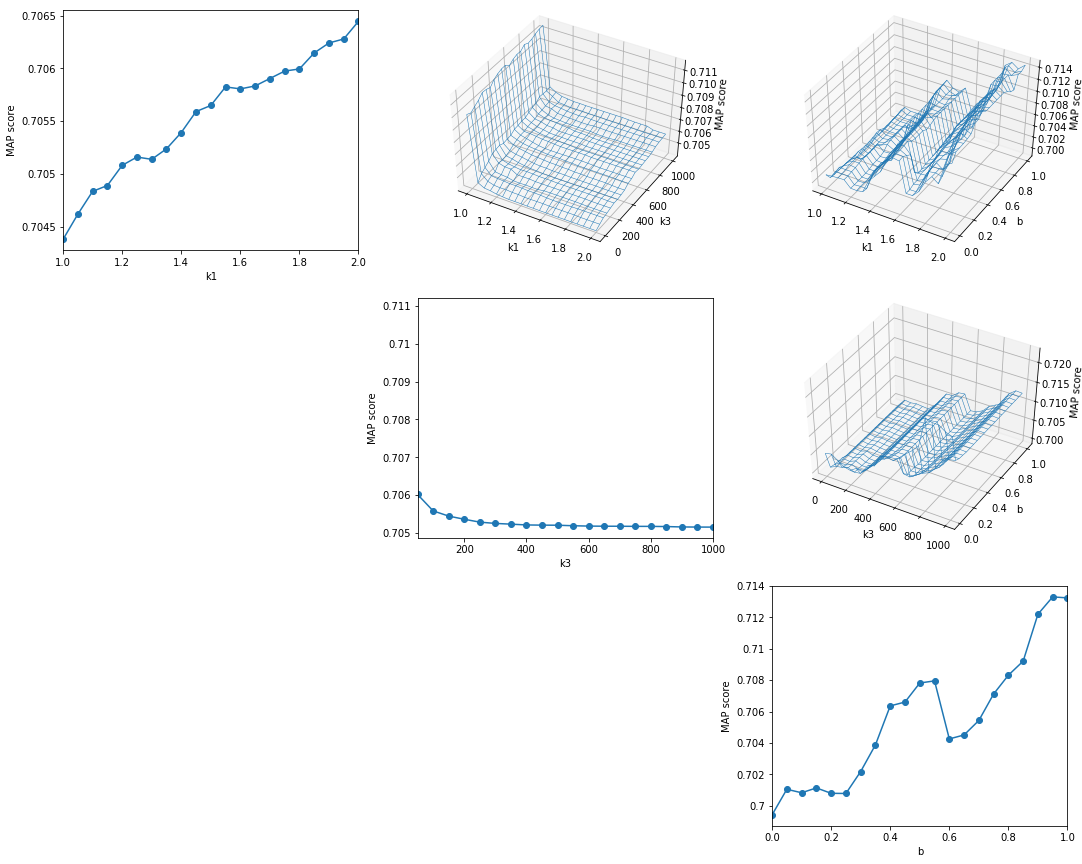

In [9]:
display_plots("segmented_ml")

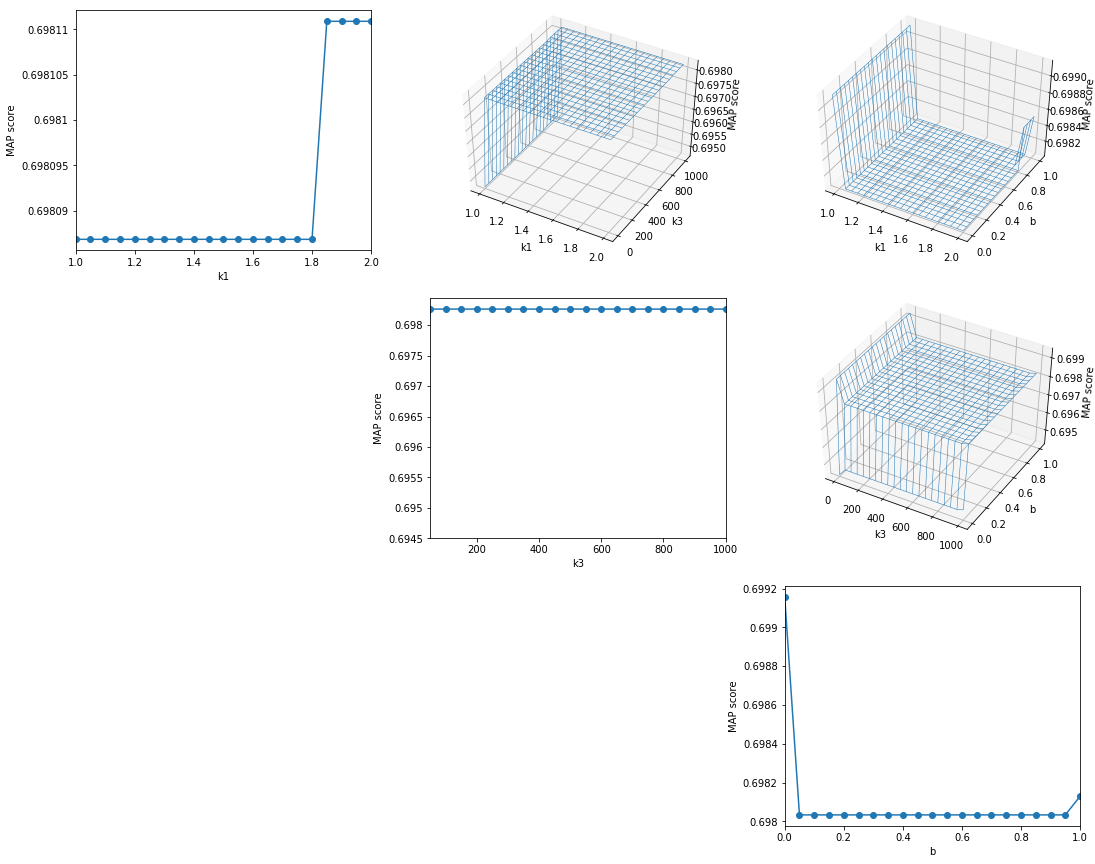

In [10]:
display_plots("unsegmented")